In [21]:
!pip install matplotlib
!pip install seaborn
!pip install h3
!pip install folium

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import h3
import folium
from folium.plugins import HeatMap

In [22]:
orders = pd.read_csv('data_orders.csv', parse_dates=['order_datetime'])
offers = pd.read_csv('data_offers.csv')
orders.head(), offers.head()

(       order_datetime  origin_longitude  origin_latitude  m_order_eta  \
 0 2025-04-22 18:08:07         -0.978916        51.456173         60.0   
 1 2025-04-22 20:57:32         -0.950385        51.456843          NaN   
 2 2025-04-22 12:07:50         -0.969520        51.455544        477.0   
 3 2025-04-22 13:50:20         -1.054671        51.460544        658.0   
 4 2025-04-22 21:24:45         -0.967605        51.458236          NaN   
 
         order_gk  order_status_key  is_driver_assigned_key  \
 0  3000583041974                 4                       1   
 1  3000583116437                 4                       0   
 2  3000582891479                 4                       1   
 3  3000582941169                 4                       1   
 4  3000583140877                 9                       0   
 
    cancellations_time_in_seconds  
 0                          198.0  
 1                          128.0  
 2                           46.0  
 3                           6

In [23]:
orders.info()
orders.isnull().sum()

orders_with_offers = orders.merge(offers, on='order_gk', how='left')

orders['hour'] = orders['order_datetime'].dt.hour
orders['date'] = orders['order_datetime'].dt.date

orders['cancellation_reason'] = np.select(
    [
        (orders['order_status_key'] == 4) & (orders['is_driver_assigned_key'] == 0),
        (orders['order_status_key'] == 4) & (orders['is_driver_assigned_key'] == 1),
        (orders['order_status_key'] == 9)
    ],
    [
        'cancelled_before_driver',
        'cancelled_after_driver',
        'rejected_by_system'
    ],
    default='other'
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  int64         
 5   order_status_key               10716 non-null  int64         
 6   is_driver_assigned_key         10716 non-null  int64         
 7   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 669.9 KB


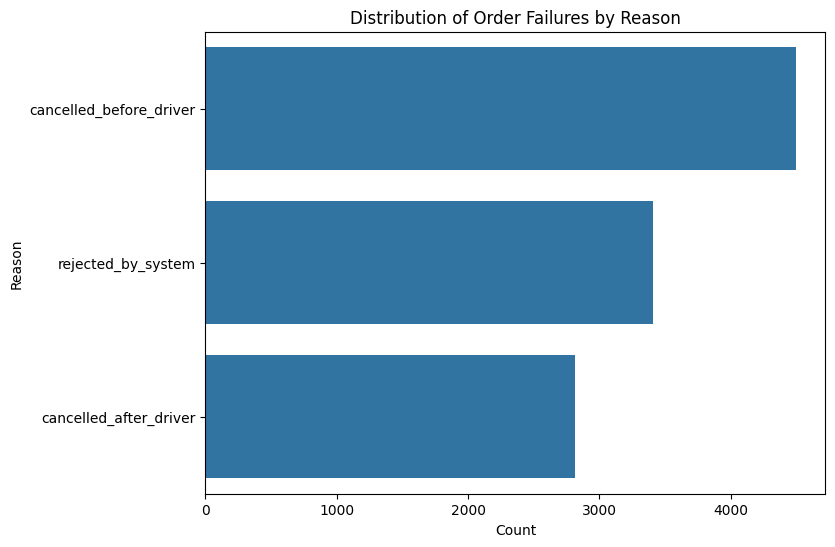

cancellation_reason
cancelled_before_driver    0.419560
rejected_by_system         0.318122
cancelled_after_driver     0.262318
Name: proportion, dtype: float64

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(y='cancellation_reason', data=orders, order=orders['cancellation_reason'].value_counts().index)
plt.title("Distribution of Order Failures by Reason")
plt.xlabel("Count")
plt.ylabel("Reason")
plt.show()

orders['cancellation_reason'].value_counts(normalize=True)

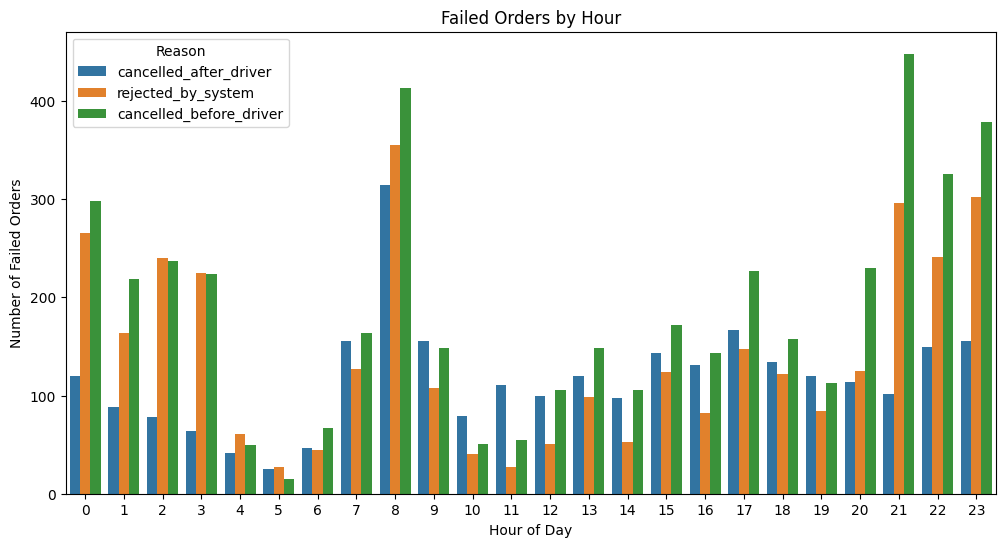

In [25]:
plt.figure(figsize=(12, 6))
sns.countplot(x='hour', hue='cancellation_reason', data=orders)
plt.title("Failed Orders by Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Failed Orders")
plt.legend(title='Reason')
plt.show()

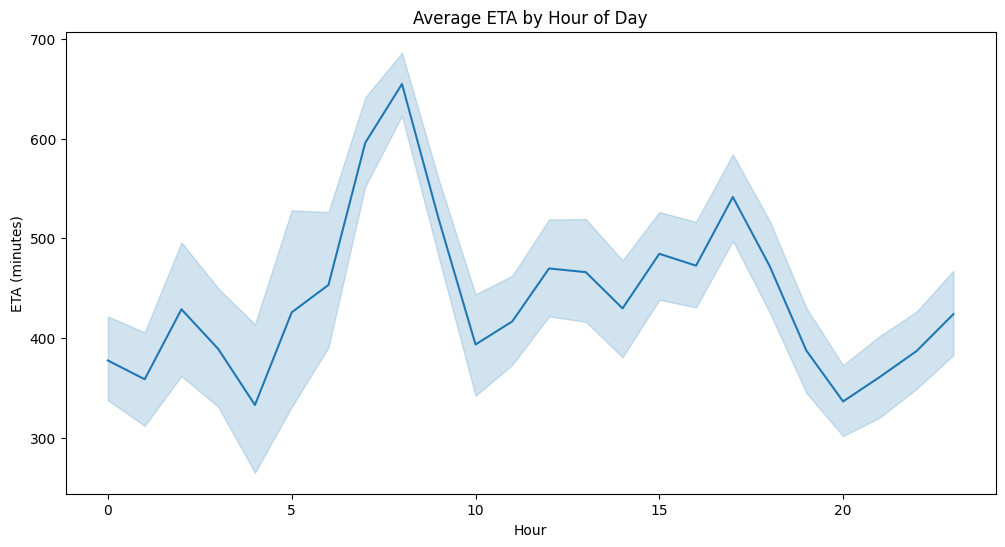

In [26]:
eta_q1 = orders['m_order_eta'].quantile(0.01)
eta_q99 = orders['m_order_eta'].quantile(0.99)
orders_eta = orders[(orders['m_order_eta'] > eta_q1) & (orders['m_order_eta'] < eta_q99)]

plt.figure(figsize=(12, 6))
sns.lineplot(data=orders_eta, x='hour', y='m_order_eta')
plt.title("Average ETA by Hour of Day")
plt.ylabel("ETA (minutes)")
plt.xlabel("Hour")
plt.show()